<a href="https://colab.research.google.com/github/NastyaParnet/evolution/blob/main/Lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import sys
import copy

# ---- BEE CLASS

class Bee(object):
    def __init__(self, lower, upper, fun, funcon=None):
        # creates a random solution vector
        self._random(lower, upper)

        # checks if the problem constraint(s) are satisfied
        if not funcon:
            self.valid = True
        else:
            self.valid = funcon(self.vector)

        # computes fitness of solution vector
        if (fun != None):
            self.value = fun(self.vector)
        else:
            self.value = sys.float_info.max
        self._fitness()

        # initialises trial limit counter - i.e. abandonment counter
        self.counter = 0

    def _random(self, lower, upper):
        self.vector = []
        for i in range(len(lower)):
            self.vector.append( lower[i] + random.random() * (upper[i] - lower[i]) )

    def _fitness(self):
        if (self.value >= 0):
            self.fitness = 1 / (1 + self.value)
        else:
            self.fitness = 1 + abs(self.value)

class BeeHive(object):
    def run(self):
        """ Runs an Artificial Bee Colony (ABC) algorithm. """

        cost = {}; cost["best"] = []; cost["mean"] = []
        for itr in range(self.max_itrs):

            # employees phase
            for index in range(self.size):
                self.send_employee(index)

            # onlookers phase
            self.send_onlookers()

            # scouts phase
            self.send_scout()

            # computes best path
            self.find_best()

            # stores convergence information
            cost["best"].append( self.best )
            cost["mean"].append( sum( [ bee.value for bee in self.population ] ) / self.size )

            # prints out information about computation
            if self.verbose:
                self._verbose(itr, cost)

        return cost

    def __init__(self                 ,
                 lower, upper         ,
                 fun          = None  ,
                 numb_bees    =  30   ,
                 max_itrs     = 100   ,
                 max_trials   = None  ,
                 selfun       = None  ,
                 seed         = None  ,
                 verbose      = False ,
                 extra_params = None ,):
        
        # checks input
        assert (len(upper) == len(lower)), "'lower' and 'upper' must be a list of the same length."

        # generates a seed for the random number generator
        if (seed == None):
            self.seed = random.randint(0, 1000)
        else:
            self.seed = seed
        random.seed(self.seed)

        # computes the number of employees
        self.size = int((numb_bees + numb_bees % 2))

        # assigns properties of algorithm
        self.dim = len(lower)
        self.max_itrs = max_itrs
        if (max_trials == None):
            self.max_trials = 0.6 * self.size * self.dim
        else:
            self.max_trials = max_trials
        self.selfun = selfun
        self.extra_params = extra_params

        # assigns properties of the optimisation problem
        self.evaluate = fun
        self.lower    = lower
        self.upper    = upper

        # initialises current best and its a solution vector
        self.best = sys.float_info.max
        self.solution = None

        # creates a bee hive
        self.population = [ Bee(lower, upper, fun) for i in range(self.size) ]

        # initialises best solution vector to food nectar
        self.find_best()

        # computes selection probability
        self.compute_probability()

        # verbosity of computation
        self.verbose = verbose

    def find_best(self):
        values = [ bee.value for bee in self.population ]
        index  = values.index(min(values))
        if (values[index] < self.best):
            self.best     = values[index]
            self.solution = self.population[index].vector

    def compute_probability(self):
        # retrieves fitness of bees within the hive
        values = [bee.fitness for bee in self.population]
        max_values = max(values)

        # computes probalities the way Karaboga does in his classic ABC implementation
        if (self.selfun == None):
            self.probas = [0.9 * v / max_values + 0.1 for v in values]
        else:
            if (self.extra_params != None):
                self.probas = self.selfun(list(values), **self.extra_params)
            else:
                self.probas = self.selfun(values)

        # returns intervals of probabilities
        return [sum(self.probas[:i+1]) for i in range(self.size)]

    def send_employee(self, index):
        # deepcopies current bee solution vector
        zombee = copy.deepcopy(self.population[index])

        # draws a dimension to be crossed-over and mutated
        d = random.randint(0, self.dim-1)

        # selects another bee
        bee_ix = index;
        while (bee_ix == index): bee_ix = random.randint(0, self.size-1)

        # produces a mutant based on current bee and bee's friend
        zombee.vector[d] = self._mutate(d, index, bee_ix)

        # checks boundaries
        zombee.vector = self._check(zombee.vector, dim=d)

        # computes fitness of mutant
        zombee.value = self.evaluate(zombee.vector)
        zombee._fitness()

        # deterministic crowding
        if (zombee.fitness > self.population[index].fitness):
            self.population[index] = copy.deepcopy(zombee)
            self.population[index].counter = 0
        else:
            self.population[index].counter += 1

    def send_onlookers(self):
        # sends onlookers
        numb_onlookers = 0; beta = 0
        while (numb_onlookers < self.size):

            # draws a random number from U[0,1]
            phi = random.random()

            # increments roulette wheel parameter beta
            beta += phi * max(self.probas)
            beta %= max(self.probas)

            # selects a new onlooker based on waggle dance
            index = self.select(beta)

            # sends new onlooker
            self.send_employee(index)

            # increments number of onlookers
            numb_onlookers += 1

    def select(self, beta):
        # computes probability intervals "online" - i.e. re-computed after each onlooker
        probas = self.compute_probability()

        # selects a new potential "onlooker" bee
        for index in range(self.size):
            if (beta < probas[index]):
                return index

    def send_scout(self):
        # retrieves the number of trials for all bees
        trials = [ self.population[i].counter for i in range(self.size) ]

        # identifies the bee with the greatest number of trials
        index = trials.index(max(trials))

        # checks if its number of trials exceeds the pre-set maximum number of trials
        if (trials[index] > self.max_trials):

            # creates a new scout bee randomly
            self.population[index] = Bee(self.lower, self.upper, self.evaluate)

            # sends scout bee to exploit its solution vector
            self.send_employee(index)

    def _mutate(self, dim, current_bee, other_bee):
        return self.population[current_bee].vector[dim]    + \
               (random.random() - 0.5) * 2                 * \
               (self.population[current_bee].vector[dim] - self.population[other_bee].vector[dim])

    def _check(self, vector, dim=None):
        if (dim == None):
            range_ = range(self.dim)
        else:
            range_ = [dim]

        for i in range_:

            # checks lower bound
            if  (vector[i] < self.lower[i]):
                vector[i] = self.lower[i]

            # checks upper bound
            elif (vector[i] > self.upper[i]):
                vector[i] = self.upper[i]

        return vector

    def _verbose(self, itr, cost):
        """ Displays information about computation. """

        msg = "# Iter = {} | Best Evaluation Value = {} | Mean Evaluation Value = {} "
        print(msg.format(int(itr), cost["best"][itr], cost["mean"][itr]))

# ---- END

In [ ]:
import random
import numpy as np

# ---- SELECTION METHOD(S)

def tournament(values, crowd_size=None):
    # computes battle score metrics
    scores = []
    for i in range(len(values)):

        # selects a pool of opponents randomly
        if (crowd_size != None) and (type(crowd_size) is int):
            opponents = random.sample(values, crowd_size)
        else:
            opponents = values

        # battles against opponents
        scores.append( sum(np.where(values[i]>opponents, 1, 0)) )

    # returns an array of normalized scores
    return scores / sum(scores)

def disruptive(values):
    # computes mean fitness of population
    mean_ = np.mean(values)

    # computes score metrics
    scores = []
    for i in range(len(values)):
        scores.append(abs(values[i] - mean_))

    # returns an array of normalized scores
    return scores / sum(scores)

# ---- END

In [ ]:
try:
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
except:
    raise ImportError("Install 'matplotlib' to plot convergence results.")

def ConvergencePlot(cost):
    font = FontProperties();
    font.set_size('larger');
    labels = ["Best Cost Function", "Mean Cost Function"]
    plt.figure(figsize=(12.5, 4));
    plt.plot(range(len(cost["best"])), cost["best"], label=labels[0]);
    plt.scatter(range(len(cost["mean"])), cost["mean"], color='red', label=labels[1]);
    plt.xlabel("Iteration #");
    plt.ylabel("Value [-]");
    plt.legend(loc="best", prop = font);
    plt.xlim([0,len(cost["mean"])]);
    plt.grid();
    plt.show();

# ---- END

time:  0.8123800754547119


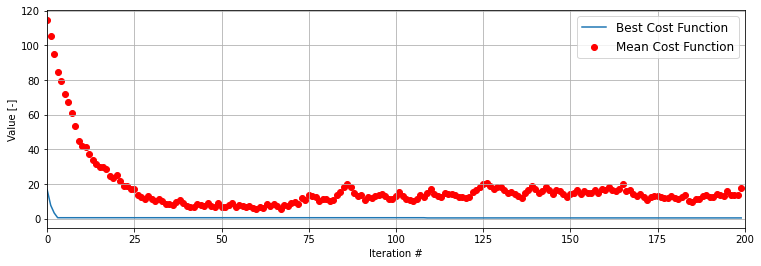

Fitness Value ABC: 0.342116615647233


In [ ]:
import time
import math
try:
    import numpy as np
except:
    raise ImportError("Numpy module not installed.")

# ---- CREATE TEST CASE

def evaluator(arg_vec):
    # s1 = (arg_vec[0]+2*arg_vec[1]-7)**2
    # s2 = (2*arg_vec[0]+arg_vec[1]-5)**2
    # return s1+s2
    return 100*math.sqrt(abs(arg_vec[1]-0.01*arg_vec[0]*arg_vec[0])) + 0.01*abs(arg_vec[0]+10)


# ---- SOLVE TEST CASE WITH ARTIFICIAL BEE COLONY ALGORITHM

def run():

    # creates model
    model = BeeHive(lower = [-15, -3],
                    upper = [-5, 3],
                    fun = evaluator,
                    numb_bees = 50,
                    max_itrs = 200,)

    start_time = time.time()
    # runs model
    cost = model.run()
    print('time: ', time.time()-start_time)

    # plots convergence
    ConvergencePlot(cost)

    # prints out best solution
    print("Fitness Value ABC: {0}".format(model.best))


if __name__ == "__main__":
    run()


# ---- END